Sử dụng 1 bộ dữ liệu time-series nhiều biến (multivariate) tại link (Liên kết đến một trang bên ngoài.)
Sử dụng 3 mô hình regression trên scikit-learn (Liên kết đến một trang bên ngoài.).
Xây dựng bài toán dự đoán time-series nhiều biến (nhiều đầu vào và nhiều đầu ra).
+ Tối ưu hóa tham số cho các mô hình trên dùng GridSearchCV. Sau đó,
+ Lập bảng kết quả so sánh đánh giá performance metrics (RMSE, MAE, R2, MAPE,...) cho các mô hình trên dựa vào tập test.
+ Vẽ đồ thị giá trị thực tế và dự đoán.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('exchange_rate.csv')
df

,Australia,Britain,Canada,Switzerland,China,Japan,New Zealand,Singapore
0,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.593000,0.525486
1,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.594000,0.523972
2,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.597300,0.526316
3,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.597000,0.523834
4,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.598500,0.527426
...,...,...,...,...,...,...,...,...
7583,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.690846,0.688565
7584,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.695701,0.690288
7585,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.695943,0.691419
7586,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.692689,0.690942


In [3]:
dataset = pd.DataFrame(df)
dataset

,Australia,Britain,Canada,Switzerland,China,Japan,New Zealand,Singapore
0,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.593000,0.525486
1,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.594000,0.523972
2,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.597300,0.526316
3,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.597000,0.523834
4,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.598500,0.527426
...,...,...,...,...,...,...,...,...
7583,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.690846,0.688565
7584,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.695701,0.690288
7585,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.695943,0.691419
7586,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.692689,0.690942


In [5]:
import pandas as pd

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [10]:
data = series_to_supervised(dataset, n_in = 3, n_out = 1)
data

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.593000,0.525486,0.781800,1.610000,...,0.597300,0.526316,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.597000,0.523834
4,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.594000,0.523972,0.786700,1.629300,...,0.597000,0.523834,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.598500,0.527426
5,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.597300,0.526316,0.786000,1.637000,...,0.598500,0.527426,0.786600,1.653700,0.861030,0.654879,0.211242,0.006887,0.604000,0.526177
6,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.597000,0.523834,0.784900,1.653000,...,0.604000,0.526177,0.788600,1.662000,0.862887,0.661157,0.211242,0.006885,0.607000,0.527565
7,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.598500,0.527426,0.786600,1.653700,...,0.607000,0.527565,0.791000,1.656800,0.864304,0.659631,0.211242,0.006878,0.608400,0.527565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7583,0.719114,1.227800,0.738089,0.973189,0.143962,0.008527,0.687687,0.691133,0.719735,1.228501,...,0.688753,0.690164,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.690846,0.688565
7584,0.719735,1.228501,0.740384,0.973047,0.143972,0.008537,0.690846,0.690978,0.718701,1.226001,...,0.690846,0.688565,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.695701,0.690288
7585,0.718701,1.226001,0.737776,0.972479,0.143833,0.008510,0.688753,0.690164,0.718494,1.222195,...,0.695701,0.690288,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.695943,0.691419
7586,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.690846,0.688565,0.721839,1.223459,...,0.695943,0.691419,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.692689,0.690942


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error

def draw_true_predict(y_true, y_pred):
    size = len(y_true)
    plt.plot(list(range(size)), y_true, label=['real_' + col for col in df.columns], color = 'blue')
    plt.plot(list(range(size)), y_pred, label=['predicted_' + col for col in df.columns], color='red')
    plt.legend(loc='best')
    plt.title('Real vs Predicted values')
    plt.show()

def calculate_metrics(y_true, y_pred):
    # Calculate metrics
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    MSE = mean_squared_error(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    print(f"RMSE: {RMSE}, MSE: {MSE}, MAE: {MAE}, MAPE: {MAPE}, R2: {R2}")

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
models = {
    'ElasticNet': ElasticNet(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
}
param_grids = {
    'ElasticNet': {
        'alpha': [0.1, 1, 10],
        'l1_ratio': [0.1, 0.5, 0.9],
        'max_iter': [1000, 2000, 3000],
        'tol': [1e-3, 1e-4, 1e-5]
    },
    'KNeighborsRegressor': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
    },
    'RandomForestRegressor': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 3, 4],
        'min_samples_leaf': [1, 2, 3]
    }
}

In [35]:
X, Y = data[['var'+str(i)+'(t-' + str(j) + ')' for i in range(1, df.shape[1]+1) for j in range(3, 0, -1)]], data[['var' + str(i) + '(t)' for i in range(1, df.shape[1]+1)]]
print(X, Y)

      var1(t-3)  var1(t-2)  var1(t-1)  var2(t-3)  var2(t-2)  var2(t-1)  \
3      0.785500   0.781800   0.786700   1.611000   1.610000   1.629300   
4      0.781800   0.786700   0.786000   1.610000   1.629300   1.637000   
5      0.786700   0.786000   0.784900   1.629300   1.637000   1.653000   
6      0.786000   0.784900   0.786600   1.637000   1.653000   1.653700   
7      0.784900   0.786600   0.788600   1.653000   1.653700   1.662000   
...         ...        ...        ...        ...        ...        ...   
7583   0.719114   0.719735   0.718701   1.227800   1.228501   1.226001   
7584   0.719735   0.718701   0.718494   1.228501   1.226001   1.222195   
7585   0.718701   0.718494   0.721839   1.226001   1.222195   1.223459   
7586   0.718494   0.721839   0.723197   1.222195   1.223459   1.234111   
7587   0.721839   0.723197   0.720825   1.223459   1.234111   1.233905   

      var3(t-3)  var3(t-2)  var3(t-1)  var4(t-3)  ...  var5(t-1)  var6(t-3)  \
3      0.861698   0.861104   0.8

In [36]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_run = X.values
Y_run = Y.values

# Split in train-test
X_train, X_test, Y_train, Y_test = train_test_split(X_run, Y_run, test_size=0.2, shuffle=False, random_state=0)
#Y_train = np.reshape(Y_train, (-1, 1))
#Y_test = np.reshape(Y_test, (-1, 1))

scaler_feature = StandardScaler()
scaler_feature.fit(X_train)
X_train_scaled = scaler_feature.transform(X_train)
X_test_scaled = scaler_feature.transform(X_test)

scaler_label = StandardScaler()
scaler_label.fit(Y_train)
Y_train_scaled = scaler_label.transform(Y_train)
Y_test_scaled = scaler_label.transform(Y_test)

Training ElasticNet...
Best parameters: {'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 1000, 'tol': 0.001}
RMSE: 0.021301531135287093, MSE: 0.00045375522870760545, MAE: 0.014706025401472745, MAPE: 0.021292842386629894, R2: 0.8098934460582422


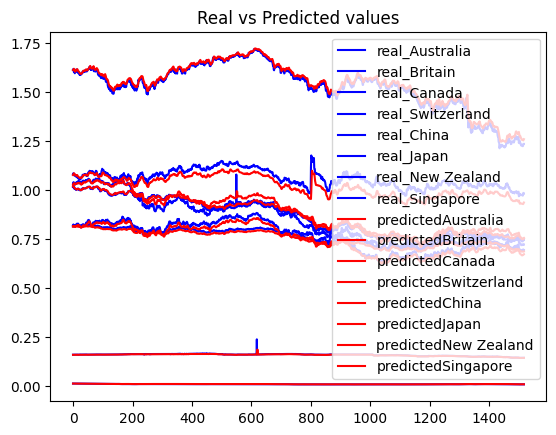

Training KNeighborsRegressor...
Best parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
RMSE: 0.06599380071896563, MSE: 0.004355181733334549, MAE: 0.03923672683397683, MAPE: 0.07240048355858317, R2: -2.765940689155367


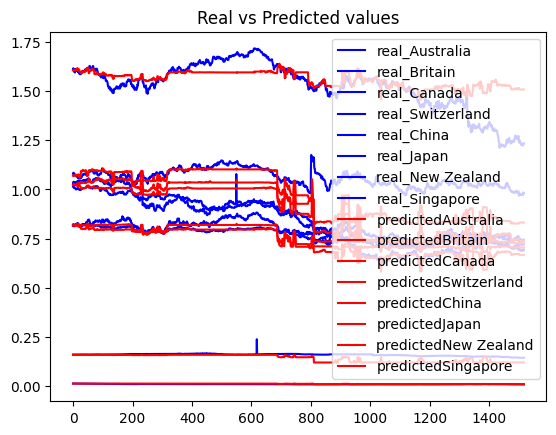

Training RandomForestRegressor...
Best parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
RMSE: 0.10504215457870691, MSE: 0.011033854238536957, MAE: 0.06335963327372053, MAPE: 0.09017442873170517, R2: -4.067108225431658


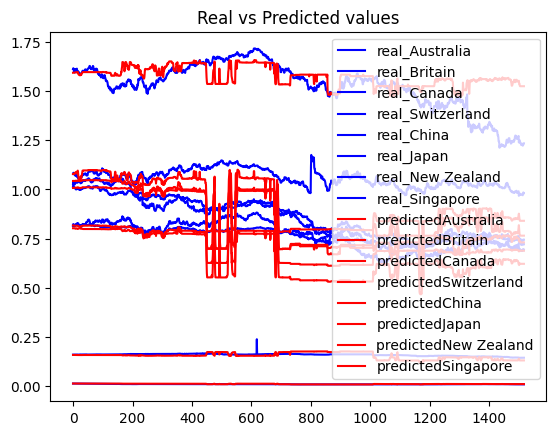

In [37]:
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=3, n_jobs=-1)
    grid_search.fit(X_train_scaled, Y_train_scaled)
    
    f = grid_search.best_params_
    print(f"Best parameters: {f}")
    model = grid_search.best_estimator_
    
    y_pred = model.predict(X_test_scaled)
    y_pred_unscaled = scaler_label.inverse_transform(y_pred)
    results[name] = y_pred_unscaled
    
    calculate_metrics(Y_test, y_pred_unscaled)
    draw_true_predict(Y_test, y_pred_unscaled)